In [1]:
import datetime as dt
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import unicodedata
from scipy.stats import chi2_contingency
pd.options.mode.copy_on_write=True

Primero cargamos los datos y comprobamos que estén bien:

In [ ]:
df_2024_limpio = pd.read_parquet("src/data/2024_Accidentalidad_Limpio.parquet")

In [3]:
df_2024_limpio

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,fecha_hora,grado_lesividad
0,2023s040280,2024-01-04,14:09:00,avda. niceto alcala zamora / autov. m-11,3,16,HORTALEZA,Colisión fronto-lateral,Lluvia débil,Motocicleta > 125cc,Conductor,De 55 a 59 años,Hombre,2.0,Ingreso inferior o igual a 24 horas,444913.0,4481427.0,Negativo,2024-01-04 14:09:00,Leve
1,2023s040280,2024-01-04,14:09:00,avda. niceto alcala zamora / autov. m-11,3,16,HORTALEZA,Colisión fronto-lateral,Lluvia débil,Turismo,Conductor,De 55 a 59 años,Mujer,14.0,Sin asistencia sanitaria,444913.0,4481427.0,Negativo,2024-01-04 14:09:00,Sin asistencia sanitaria
2,2023s040309,2024-02-15,14:05:00,call. tesoro / call. minas,18,1,CENTRO,Colisión fronto-lateral,Lluvia débil,Bicicleta,Conductor,De 25 a 29 años,Hombre,7.0,Asistencia sanitaria sólo en el lugar del acci...,440123.0,4475170.0,Negativo,2024-02-15 14:05:00,Leve
3,2023s040309,2024-02-15,14:05:00,call. tesoro / call. minas,18,1,CENTRO,Colisión fronto-lateral,Lluvia débil,Motocicleta hasta 125cc,Conductor,De 35 a 39 años,Hombre,14.0,Sin asistencia sanitaria,440123.0,4475170.0,Negativo,2024-02-15 14:05:00,Sin asistencia sanitaria
4,2023s040310,2024-02-18,10:40:00,gta. ruiz jimenez / call. san bernardo,3,7,CHAMBERÍ,Colisión lateral,Despejado,Turismo,Conductor,De 25 a 29 años,Hombre,14.0,Sin asistencia sanitaria,440137.0,4475721.0,Negativo,2024-02-18 10:40:00,Sin asistencia sanitaria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49335,2024s035474,2024-12-23,11:35:00,call. lucano / call. canal del bosforo,1,20,SAN BLAS-CANILLEJAS,Otro,Despejado,Camión rígido,Conductor,De 25 a 29 años,Hombre,14.0,Sin asistencia sanitaria,448109.0,4476801.0,Negativo,2024-12-23 11:35:00,Sin asistencia sanitaria
49336,2024s035479,2024-12-03,09:45:00,gta. san vicente / avda. portugal,1,9,MONCLOA-ARAVACA,Otro,Despejado,Autobús,Conductor,De 40 a 44 años,Hombre,14.0,Sin asistencia sanitaria,438883.0,4474597.0,Negativo,2024-12-03 09:45:00,Sin asistencia sanitaria
49337,2024s035479,2024-12-03,09:45:00,gta. san vicente / avda. portugal,1,9,MONCLOA-ARAVACA,Otro,Despejado,Turismo,Conductor,De 50 a 54 años,Hombre,14.0,Sin asistencia sanitaria,438883.0,4474597.0,Negativo,2024-12-03 09:45:00,Sin asistencia sanitaria
49338,2024s035480,2024-12-29,19:15:00,plaza. cibeles / call. alcala,1,3,RETIRO,Colisión fronto-lateral,Despejado,Turismo,Conductor,De 35 a 39 años,Hombre,14.0,Sin asistencia sanitaria,441193.0,4474551.0,Negativo,2024-12-29 19:15:00,Sin asistencia sanitaria


In [4]:
df_2024_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47284 entries, 0 to 49339
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num_expediente        47284 non-null  object        
 1   fecha                 47284 non-null  datetime64[ns]
 2   hora                  47284 non-null  object        
 3   localizacion          47284 non-null  object        
 4   numero                47284 non-null  object        
 5   cod_distrito          47284 non-null  int64         
 6   distrito              47284 non-null  category      
 7   tipo_accidente        47284 non-null  category      
 8   estado_meteorológico  47284 non-null  category      
 9   tipo_vehiculo         47284 non-null  category      
 10  tipo_persona          47284 non-null  category      
 11  rango_edad            47284 non-null  category      
 12  sexo                  47284 non-null  category      
 13  cod_lesividad        

Añado la categoría de franjas horarias:

In [5]:
df_2024_limpio['franja_horaria'] = pd.cut(
        df_2024_limpio['fecha_hora'].dt.hour,
        bins=[0,6,12,18,24],
        labels=['Madrugada','Mañana','Tarde','Noche'],
        right=False
    )
df_2024_limpio["franja_horaria"] = df_2024_limpio["franja_horaria"].astype('category')

## Análisis temporal

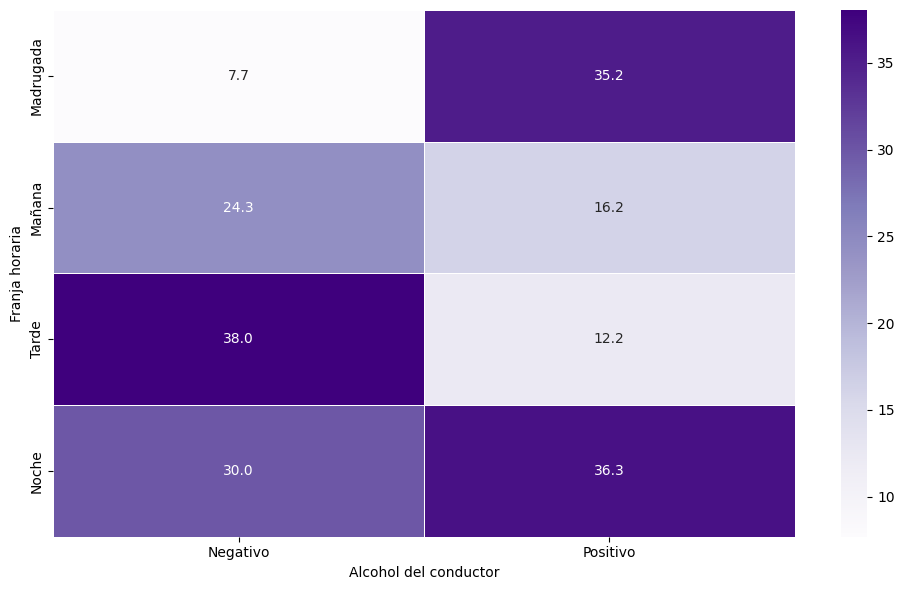

In [66]:
# 1. Copia del dataset 
df = df_2024_limpio.copy()

# 2. Filtrar alcohol registrado (opcional pero recomendable)
df = df[df["positiva_alcohol"] != "No consta"]

# 5. Filtrar solo conductores para clasificar el accidente
df_cond = df[df["tipo_persona"].str.lower() == "conductor"]

# 6. Clasificar accidente según alcohol del conductor
alcohol_accidente = df_cond.groupby("num_expediente")["positiva_alcohol"].apply(
    lambda x: "Positivo" if "Positivo" in x.values else "Negativo"
).reset_index().rename(columns={"positiva_alcohol": "alcohol_accidente"})

# 7. Unir clasificación al dataframe original
df = df.merge(alcohol_accidente, on="num_expediente", how="left")

# 8. Tabla absoluta: Alcohol del accidente × Franja (accidentes únicos)
tabla_abs = pd.crosstab(
    df["franja_horaria"],
    df["alcohol_accidente"],
    values=df["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

# 9. Convertir a porcentajes por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

# 10. Heatmap en porcentaje
plt.figure(figsize=(10,6))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Purples",
    linewidths=.5
)

# plt.title("Alcohol del conductor × Franja horaria (accidentes únicos) — % por columna")
plt.xlabel("Alcohol del conductor")
plt.ylabel("Franja horaria")
plt.tight_layout()

# Guardar figura
plt.savefig("src/img/alcohol-franja_horaria.png")

plt.show()

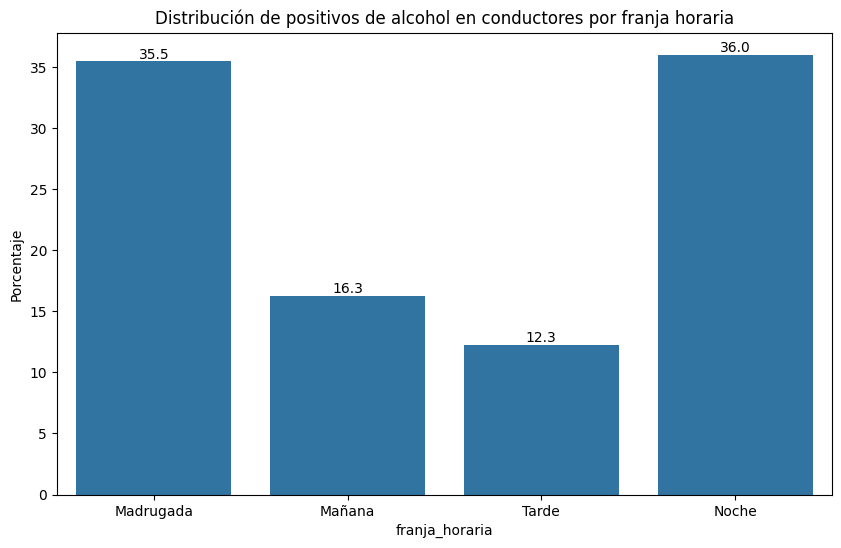

In [7]:
df_pos = df_2024_limpio[df_2024_limpio["positiva_alcohol"] == "Positivo"]

# 5. Filtrar solo conductores para clasificar el accidente
df_cond = df_pos[df_pos["tipo_persona"].str.lower() == "conductor"]

# 6. Clasificar accidente según alcohol del conductor
alcohol_accidente = df_cond.groupby("num_expediente")["positiva_alcohol"].apply(
    lambda x: "Positivo" if "Positivo" in x.values else "Negativo"
).reset_index().rename(columns={"positiva_alcohol": "alcohol_accidente"})

# 7. Unir clasificación al dataframe original
df_pos = df_pos.merge(alcohol_accidente, on="num_expediente", how="left")

fig, ax = plt.subplots(figsize=(10,6))

tabla = (
    df_pos["franja_horaria"]
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)

tabla.columns = ["franja_horaria", "porcentaje"]

sns.barplot(
    data=tabla,
    x="franja_horaria",
    y="porcentaje",
    ax=ax
)

ax.set_title("Distribución de positivos de alcohol en conductores por franja horaria")
ax.set_ylabel("Porcentaje")

for container in ax.containers:
    ax.bar_label(container, fmt="%.1f")

plt.show()


## Análisis geográfico

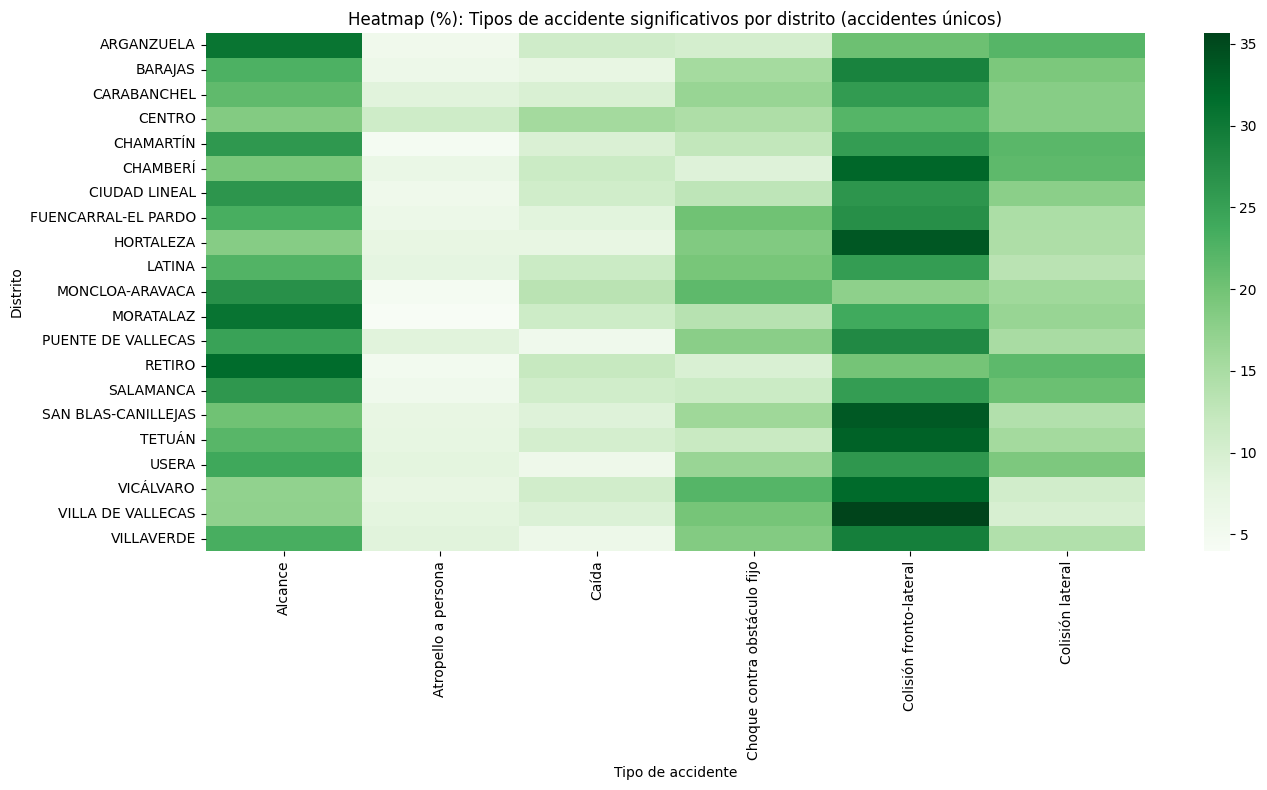

In [62]:
# 1. Definir los tipos de accidente significativos
tipos_significativos = [
    "Colisión fronto-lateral",
    "Alcance",
    "Colisión lateral",
    "Choque contra obstáculo fijo",
    "Caída",
    "Atropello a persona"
]

# 2. Filtrar el DataFrame original
df_filtrado = df_2024_limpio[
    df_2024_limpio["tipo_accidente"].isin(tipos_significativos)
]

# 3. Tabla de contingencia con expedientes únicos
tabla_contingencia = pd.crosstab(
    df_filtrado["distrito"],
    df_filtrado["tipo_accidente"],
    values=df_filtrado["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

# 4. Convertir a porcentajes por fila (por distrito)
tabla_porcentajes = tabla_contingencia.div(tabla_contingencia.sum(axis=1), axis=0) * 100

# 5. Heatmap en porcentajes
plt.figure(figsize=(14,8))
sns.heatmap(tabla_porcentajes, cmap="Greens")
plt.title("Heatmap (%): Tipos de accidente significativos por distrito (accidentes únicos)")
plt.xlabel("Tipo de accidente")
plt.ylabel("Distrito")
plt.tight_layout()

plt.savefig("src/img/accidente-distrito.png")
plt.show()



## Análisis demográfico

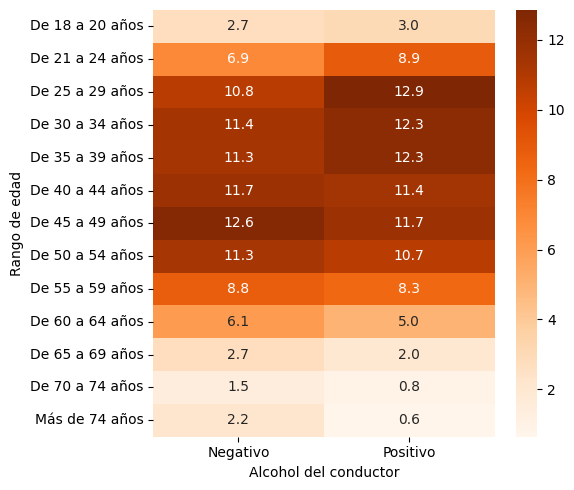

In [8]:
# 1. Filtrar solo conductores
df_conductores = df_2024_limpio[
    df_2024_limpio["tipo_persona"].str.lower() == "conductor"
].copy()

# 2. Eliminar menores de edad
rangos_menores = ["De 6 a 9 años", "De 10 a 14 años", "De 15 a 17 años"]
df_conductores = df_conductores[~df_conductores["rango_edad"].isin(rangos_menores)]

# 3. Eliminar alcohol = "No consta"
df_conductores = df_conductores[df_conductores["positiva_alcohol"] != "No consta"]

# 4. Eliminar rango_edad desconocido
df_conductores = df_conductores[df_conductores["rango_edad"] != "Desconocido"]

# 5. Clasificar accidentes según alcohol (tu propuesta)
# Si algún conductor del accidente dio positivo → accidente positivo
clasificacion_accidente = (
    df_conductores.groupby("num_expediente")["positiva_alcohol"]
    .apply(lambda x: "Positivo" if (x == "Positivo").any() else "Negativo")
    .reset_index()
)

# 6. Añadir la clasificación al dataframe de conductores
df_conductores = df_conductores.merge(clasificacion_accidente, on="num_expediente")

# 7. Tabla de contingencia: Rango de edad × Alcohol (por accidente único)
tabla_edad_alcohol = pd.crosstab(
    df_conductores["rango_edad"],
    df_conductores["positiva_alcohol_y"],  # columna creada por el merge
    values=df_conductores["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

# 8. Normalizar por columna (cada columna = 100%)
tabla_edad_alcohol_pct = tabla_edad_alcohol.div(
    tabla_edad_alcohol.sum(axis=0), axis=1
) * 100

# 9. Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(tabla_edad_alcohol_pct, annot=True, fmt=".1f", cmap="Oranges")
# plt.title("Alcohol × Rango de edad (clasificación por accidente único)")
plt.xlabel("Alcohol del conductor")
plt.ylabel("Rango de edad")
plt.tight_layout()

plt.savefig("src/img/alcohol-edad.png")
plt.show()


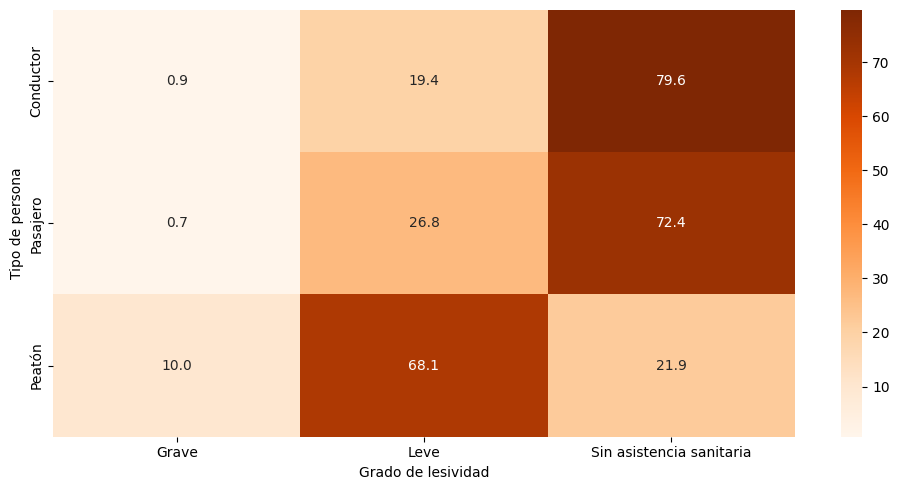

In [42]:
# Copia del dataframe
df = df_2024_limpio.copy()

# 1. Eliminar registros sin lesividad válida
df = df[df["grado_lesividad"] != "Se desconoce"]

# 2. Eliminar fallecidos
df = df[df["grado_lesividad"] != "Fallecido"]

# 3. Tabla absoluta (PERSONAS)
tabla_abs = pd.crosstab(
    df["tipo_persona"],
    df["grado_lesividad"]
)

# 4. Tabla porcentual por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=1), axis=0) * 100

# 5. Heatmap
plt.figure(figsize=(10,5))
sns.heatmap(tabla_pct, annot=True, fmt=".1f", cmap="Oranges")
# plt.title("Tipo de persona × Grado de lesividad — % por columna (sin 'Fallecido')")
plt.xlabel("Grado de lesividad")
plt.ylabel("Tipo de persona")
plt.tight_layout()

plt.savefig("src/img/lesividad-persona.png")
plt.show()


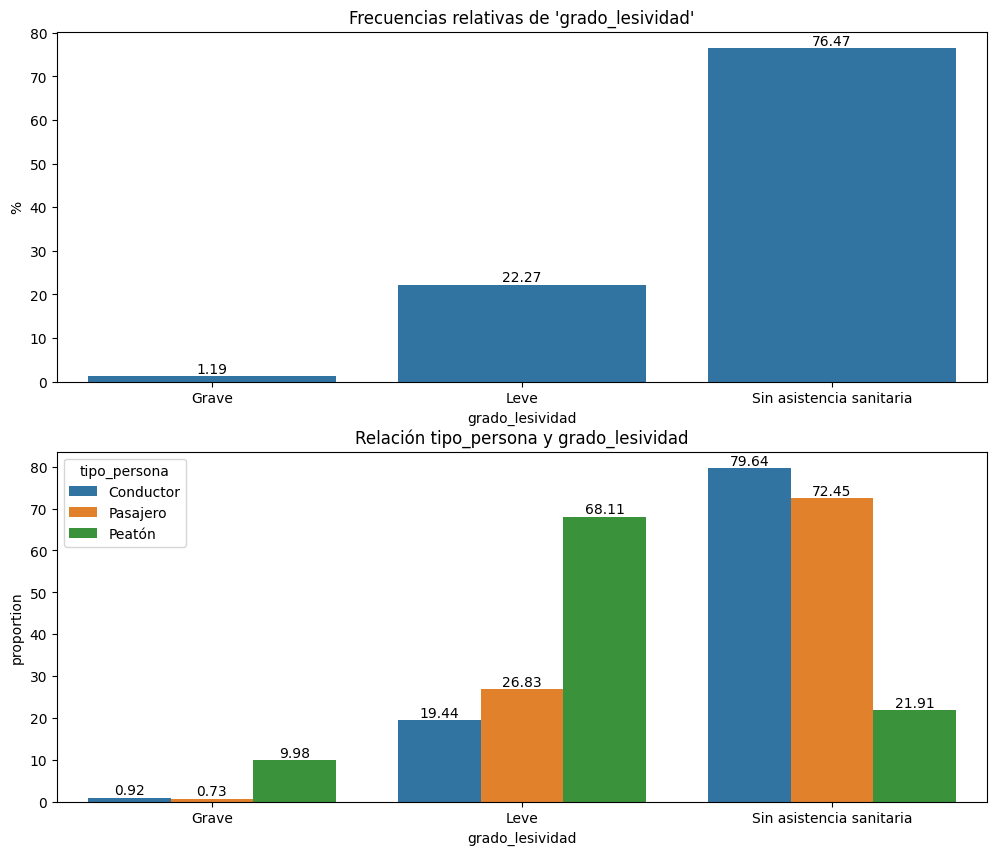

In [ ]:
lesividades = ["Grave", "Leve", "Sin asistencia sanitaria"]
df = df_2024_limpio[
    df_2024_limpio["grado_lesividad"].isin(lesividades)
]


frecuencias_relativas = df.groupby("tipo_persona", as_index = False, observed= True)["grado_lesividad"].value_counts(normalize = True)
frecuencias_relativas["proportion"] = (frecuencias_relativas["proportion"] * 100).round(2)

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 10))

# Frecuencias relativas
valores = ((df_2024_limpio["grado_lesividad"].value_counts(normalize=True)*100).round(2).loc[lesividades])
sns.barplot(x = valores.index, y = valores.values, order = valores.index, ax = axs[0])
axs[0].set_title("Frecuencias relativas de 'grado_lesividad'")
axs[0].set_ylabel("%")
for container in axs[0].containers:
    axs[0].bar_label(container)

# Bivariante
sns.barplot(data = frecuencias_relativas,
            x = "grado_lesividad",
            y = "proportion",
            hue = "tipo_persona",
            order = lesividades,
            ax = axs[1])
plt.title("Relación tipo_persona y grado_lesividad")
for container in axs[1].containers:
    axs[1].bar_label(container)

plt.show()

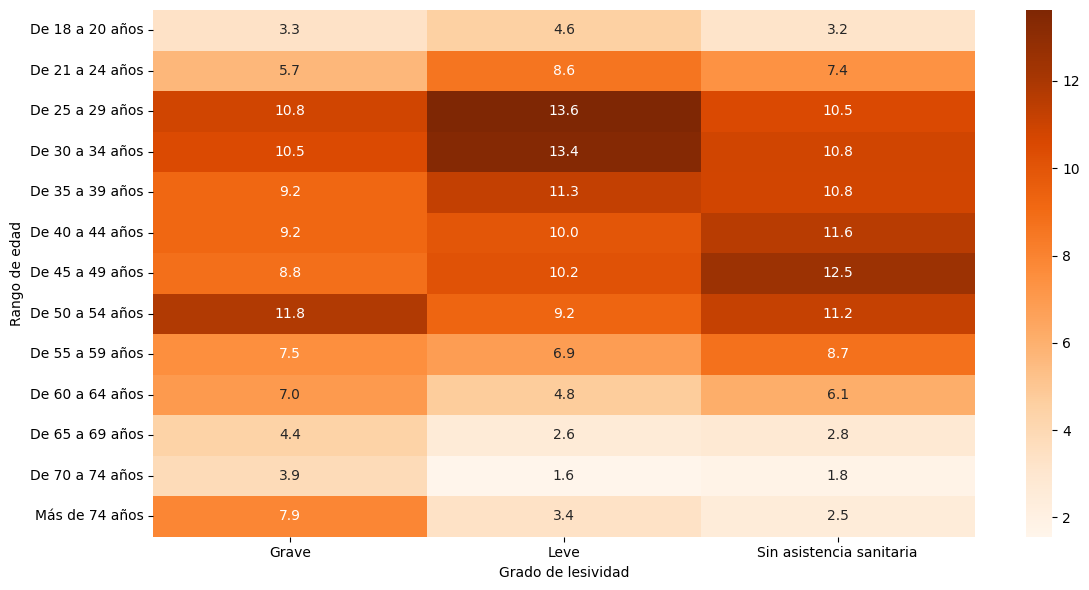

In [44]:
# Copia del dataframe
df = df_2024_limpio.copy()

# 1. Eliminar registros sin lesividad válida
df = df[df["grado_lesividad"] != "Se desconoce"]

# 2. Eliminar fallecidos
df = df[df["grado_lesividad"] != "Fallecido"]

# 3. Eliminar edades desconocidas
df = df[df["rango_edad"] != "Desconocido"]

# 4. Eliminar menores de 18 años
rangos_menores = [
    "Menor de 5 años",
    "De 6 a 9 años",
    "De 10 a 14 años",
    "De 15 a 17 años"
]
df = df[~df["rango_edad"].isin(rangos_menores)]

# 5. Orden correcto de los rangos de edad (solo adultos)
orden_edades_adultos = [
    "De 18 a 20 años",
    "De 21 a 24 años",
    "De 25 a 29 años",
    "De 30 a 34 años",
    "De 35 a 39 años",
    "De 40 a 44 años",
    "De 45 a 49 años",
    "De 50 a 54 años",
    "De 55 a 59 años",
    "De 60 a 64 años",
    "De 65 a 69 años",
    "De 70 a 74 años",
    "Más de 74 años"
]
df["rango_edad"] = pd.Categorical(df["rango_edad"], categories=orden_edades_adultos, ordered=True)

# 6. Tabla absoluta
tabla_abs = pd.crosstab(df["rango_edad"], df["grado_lesividad"])

# 7. Tabla porcentual por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

# 8. Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(tabla_pct, annot=True, fmt=".1f", cmap="Oranges")
# plt.title("Rango de edad × Grado de lesividad — % por columna (solo adultos, sin 'Fallecido')")
plt.xlabel("Grado de lesividad")
plt.ylabel("Rango de edad")
plt.tight_layout()

plt.savefig("src/img/edad-lesividad.png")
plt.show()

## Gravedad del accidente

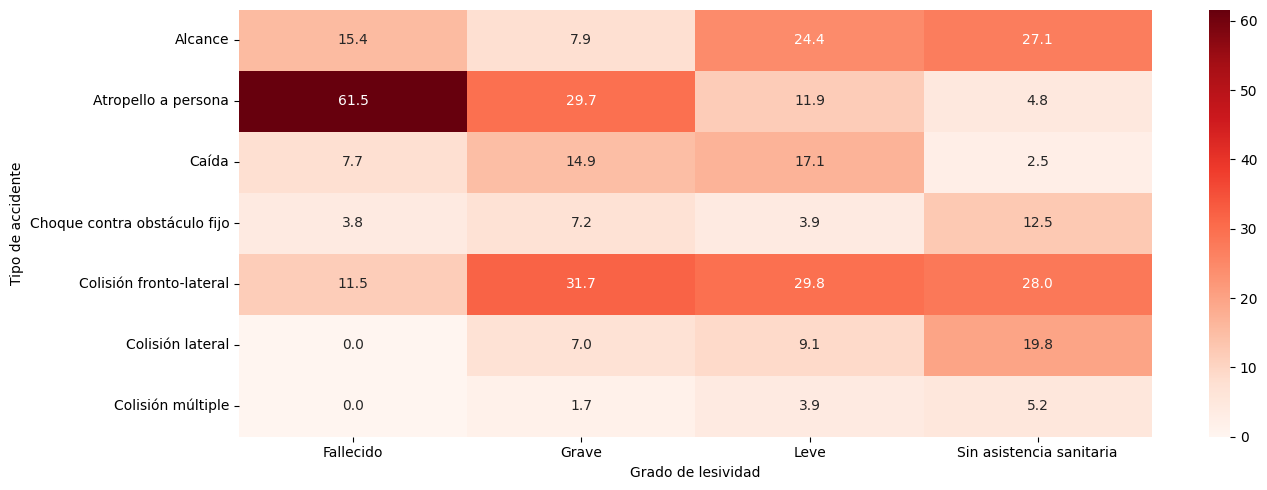

In [67]:
# Copia del dataframe
df = df_2024_limpio.copy()

# 1. Eliminar registros sin lesividad válida
df = df[df["grado_lesividad"] != "Se desconoce"]

# 3. Mantener SOLO los 7 tipos de accidente seleccionados
tipos_validos = [
    "Colisión fronto-lateral",
    "Alcance",
    "Colisión lateral",
    "Choque contra obstáculo fijo",
    "Caída",
    "Atropello a persona",
    "Colisión múltiple"
]

df = df[df["tipo_accidente"].isin(tipos_validos)]

# 4. Ordenar categorías de lesividad (ya sin fallecido)
orden_lesividad = [
    "Fallecido",
    "Grave",
    "Leve",
    "Sin asistencia sanitaria",
]

df["grado_lesividad"] = pd.Categorical(df["grado_lesividad"],
                                       categories=orden_lesividad,
                                       ordered=True)

# 5. Tabla absoluta
tabla_abs = pd.crosstab(
    df["tipo_accidente"],
    df["grado_lesividad"]
)


# 6. Tabla porcentual por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

# 7. Heatmap
plt.figure(figsize=(14,5))
sns.heatmap(tabla_pct, annot=True, fmt=".1f",  cmap="Reds")
# plt.title("Tipo de accidente × Grado de lesividad — % por columna")
plt.xlabel("Grado de lesividad")
plt.ylabel("Tipo de accidente")
plt.tight_layout()

plt.savefig("src/img/lesividad-accidente")
plt.show()


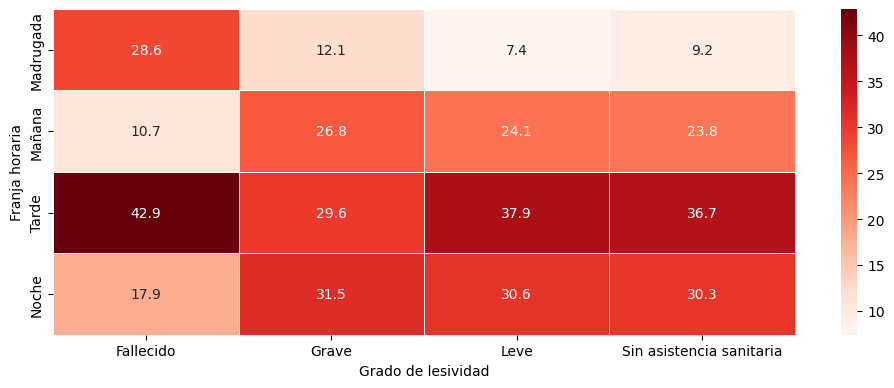

In [69]:
# 1. Copia del dataset
df = df_2024_limpio.copy()

# 4. Eliminar categoría "Se desconoce" en grado_lesividad 
df = df[df["grado_lesividad"] != "Se desconoce"]

# 5. Tabla absoluta: Franja × Grado de lesividad (accidentes únicos)
tabla_abs = pd.crosstab(
    df["franja_horaria"],
    df["grado_lesividad"],
    values=df["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)
# 6. Convertir a porcentajes por columna (cada columna suma 100%)
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

# 7. Heatmap en porcentaje
plt.figure(figsize=(10,4))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Reds",
    linewidths=.5,
)

# plt.title("Franja horaria × Grado de lesividad (accidentes únicos) — % por columna")
plt.xlabel("Grado de lesividad")
plt.ylabel("Franja horaria")
plt.tight_layout()

plt.savefig("src/img/horario-lesividad")
plt.show()

## Factores asociados al accidente

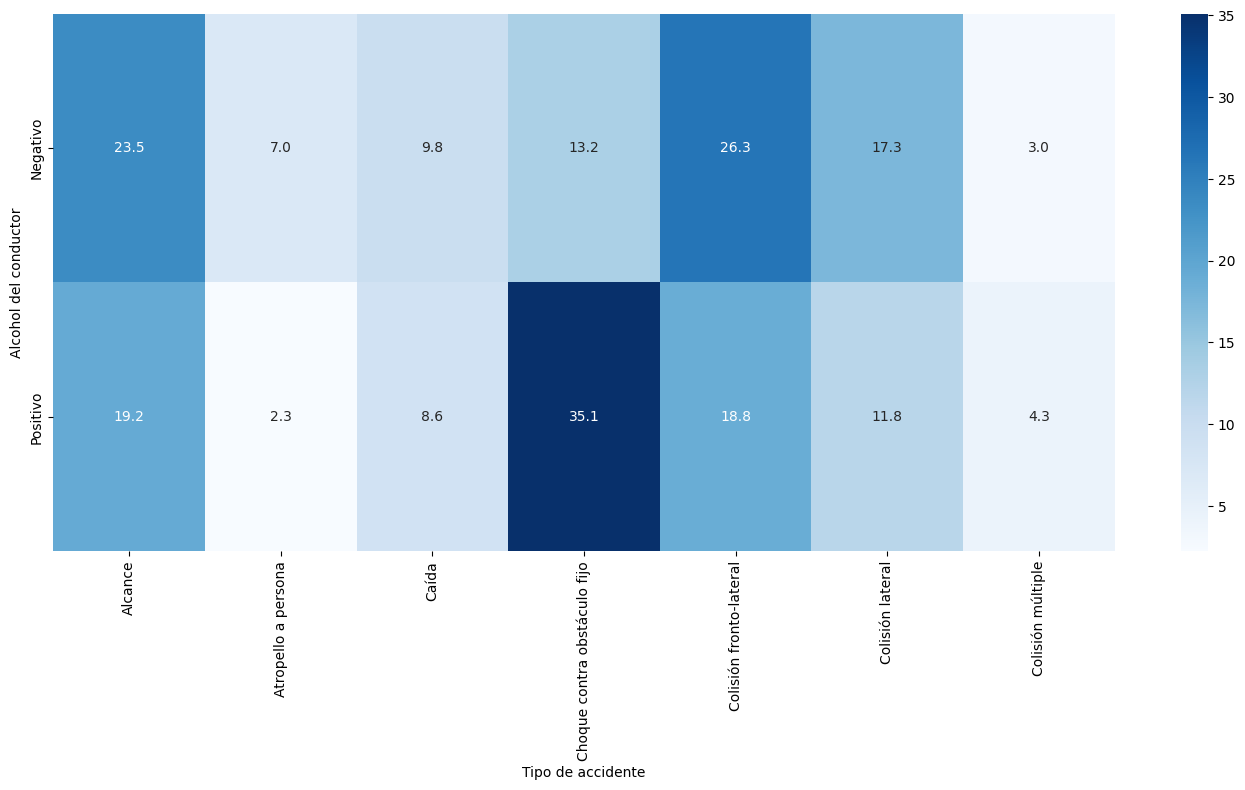

In [87]:
# 1. Tipos de accidente relevantes
tipos_significativos = [
    "Colisión fronto-lateral",
    "Alcance",
    "Colisión lateral",
    "Choque contra obstáculo fijo",
    "Caída",
    "Atropello a persona",
    "Colisión múltiple"
]

# 2. Filtrar solo conductores + tipos relevantes
df_conductores = df_2024_limpio[
    (df_2024_limpio["tipo_persona"].str.lower() == "conductor") &
    (df_2024_limpio["tipo_accidente"].isin(tipos_significativos))
]

# 3. Quitar "No consta" en alcohol
df_conductores = df_conductores[
    df_conductores["positiva_alcohol"] != "No consta"
]

# 4. Clasificar accidentes:
#    - Si algún conductor dio "Positivo" → "Positivo"
#    - Si todos dieron "Negativo" → "Negativo"
clasificacion_accidentes = (
    df_conductores
    .groupby("num_expediente")["positiva_alcohol"]
    .apply(lambda x: "Positivo" if x.str.lower().str.contains("pos", na=False).any() else "Negativo")
    .reset_index()
)

# 5. Añadir tipo de accidente (único por expediente)
tipos_por_accidente = (
    df_conductores.groupby("num_expediente")["tipo_accidente"]
    .first()
    .reset_index()
)

# 6. Unir clasificación + tipo de accidente
df_accidentes_clasificados = clasificacion_accidentes.merge(
    tipos_por_accidente, on="num_expediente"
)

# 7. Tabla de contingencia (accidentes únicos)
ct = pd.crosstab(
    df_accidentes_clasificados["positiva_alcohol"],
    df_accidentes_clasificados["tipo_accidente"]
)

# 8. Convertir a porcentajes por fila
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

# 9. Heatmap de porcentajes
plt.figure(figsize=(14,8))
sns.heatmap(ct_pct, annot=True, fmt=".1f", cmap="Blues")
# plt.title("Alcohol × Tipo de accidente (% sobre accidentes únicos clasificados)")
plt.xlabel("Tipo de accidente")
plt.ylabel("Alcohol del conductor")
plt.tight_layout()

plt.savefig("src/img/accidente-alcohol")
plt.show()


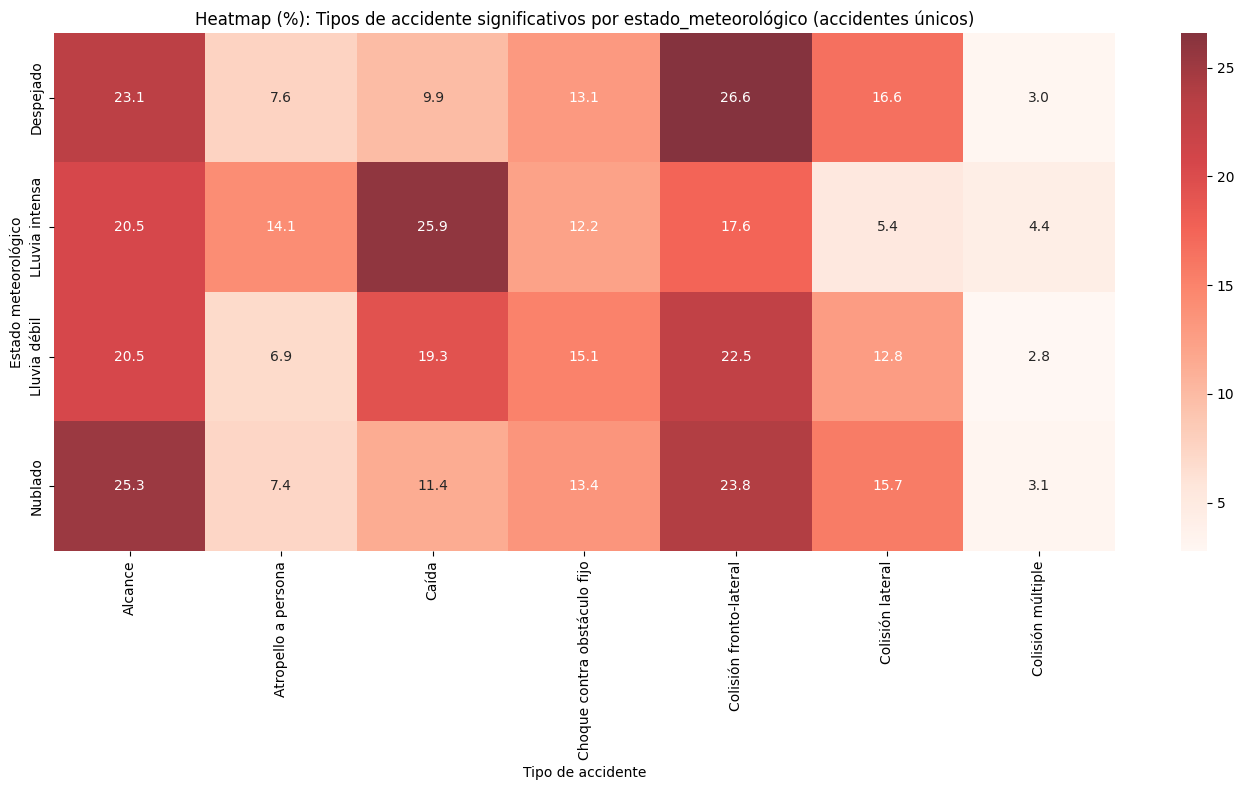

In [ ]:
# 1. Definir los tipos de accidente significativos
tipos_significativos = [
    "Colisión fronto-lateral",
    "Alcance",
    "Colisión lateral",
    "Choque contra obstáculo fijo",
    "Caída",
    "Atropello a persona",
    "Colisión múltiple"
]

estados = ["Despejado", "Nublado", "Lluvia débil", "LLuvia intensa"]

# 2. Filtrar el DataFrame original
df_filtrado = df_2024_limpio[
    df_2024_limpio["tipo_accidente"].isin(tipos_significativos) &
    df_2024_limpio["estado_meteorológico"].isin(estados)
]

# 3. Tabla de contingencia con expedientes únicos
tabla_contingencia = pd.crosstab(
    df_filtrado["estado_meteorológico"],
    df_filtrado["tipo_accidente"],
    values=df_filtrado["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

# 4. Convertir a porcentajes por fila 
tabla_porcentajes = tabla_contingencia.div(tabla_contingencia.sum(axis=1), axis=0) * 100

# 5. Heatmap en porcentajes
plt.figure(figsize=(14,8))
sns.heatmap(tabla_porcentajes, annot=True, fmt=".1f", cmap="Blues")
plt.title("Heatmap (%): Tipos de accidente significativos por estado_meteorológico (accidentes únicos)")
plt.xlabel("Tipo de accidente")
plt.ylabel("Estado meteorológico")
plt.tight_layout()

plt.savefig("src/img/accidente-tiempo")
plt.show()